# Convolutional Neural Networks

## Algorithm for a Dog Identification

---

## Import Datasets

Human and dog datasets:

* Download the [dog dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip).  Unzip the folder and place it in this project's home directory, at the location `/dog_images`. 

* Download the [human dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip).  Unzip the folder and place it in the home directory, at location `/lfw`.  

*Note: If you are using a Windows machine, you are encouraged to use [7zip](http://www.7-zip.org/) to extract the folder.*

In [1]:
import numpy as np
from glob import glob

# load filenames for human and dog images
human_files = np.array(glob("/data/lfw/*/*"))
dog_files = np.array(glob("/data/dog_images/*/*/*"))

# print number of images in each dataset
print('There are %d total human images.' % len(human_files))
print('There are %d total dog images.' % len(dog_files))

There are 13233 total human images.
There are 8351 total dog images.


## Detect Humans

In this section, we use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  

OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.

Number of faces detected: 1


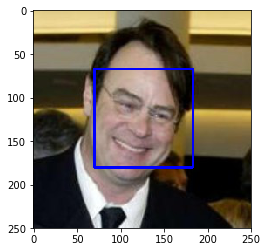

In [2]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[0])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

### Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [3]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### Assess the Human Face Detector

- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 
(You can print out your results and/or write your percentages in this cell)

In [4]:
from tqdm import tqdm

human_files_short = human_files[:100]
dog_files_short = dog_files[:100]

## Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.
human_counter = 0
dog_counter = 0
for image_path in human_files_short:
    if(face_detector(image_path)):
        human_counter += 1
for image_path in dog_files_short:
    if(face_detector(image_path)):
        dog_counter += 1
print(f'Human Detection Accuracy in Human Files: {human_counter}%')
print(f'Human Detection Accuracy in Dog Files: {dog_counter}%')

Human Detection Accuracy in Human Files: 98%
Human Detection Accuracy in Dog Files: 17%


---
## Detect Dogs

In this section, we use a [pre-trained model](http://pytorch.org/docs/master/torchvision/models.html) to detect dogs in images.  

### Obtain Pre-trained VGG-16 Model

The code cell below downloads the VGG-16 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).

In [6]:
import torch
import torchvision.models as models

# define VGG16 model
VGG16 = models.vgg16(pretrained=True)

# check if CUDA is available
use_cuda = torch.cuda.is_available()

# move model to GPU if CUDA is available
if use_cuda:
    VGG16 = VGG16.cuda()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.torch/models/vgg16-397923af.pth
100%|██████████| 553433881/553433881 [00:05<00:00, 99699798.95it/s] 


Given an image, this pre-trained VGG-16 model returns a prediction (derived from the 1000 possible categories in ImageNet) for the object that is contained in the image.

### Making Predictions with a Pre-trained Model

In the next code cell, a function that accepts a path to an image (such as `'dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg'`) as input and returns the index corresponding to the ImageNet class that is predicted by the pre-trained VGG-16 model.  The output should always be an integer between 0 and 999, inclusive.

In [29]:
from PIL import Image
import torchvision.transforms as transforms

def VGG16_predict(img_path):
    '''
    Use pre-trained VGG-16 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to VGG-16 model's prediction
    '''
    
    ## Load and pre-process an image from the given img_path
    ## Return the *index* of the predicted class for that image
    
    ##format image path into proper image
    data_transform = transforms.Compose([transforms.CenterCrop(224),
                                         transforms.ToTensor()])
    image = Image.open(img_path).convert('RGB')
    image = data_transform(image)[:3,:,:].unsqueeze(0)
    image = image.cuda()
    output = VGG16(image)
    #Find max and return index of it
    max_index = 0
    for i in range(len(output[0])):
        if(output[0, max_index] < output[0, i]):
            max_index = i
    return max_index # predicted class index

### Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained VGG-16 model, we need only check if the pre-trained model predicts an index between 151 and 268 (inclusive).

In [30]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    prediction = VGG16_predict(img_path)
    if(prediction >= 151 and prediction <=268):
        return True
    else:
        return False

### Assess the Dog Detector
 
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 


In [31]:
### Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.
human_counter = 0
dog_counter = 0
for image_path in human_files_short:
    if(dog_detector(image_path)):
        human_counter += 1
for image_path in dog_files_short:
    if(dog_detector(image_path)):
        dog_counter += 1
print(f'Dog Detection Accuracy in Human Files: {human_counter}%')
print(f'Dog Detection Accuracy in Dog Files: {dog_counter}%')

Dog Detection Accuracy in Human Files: 0%
Dog Detection Accuracy in Dog Files: 59%


---
## A CNN to Classify Dog Breeds

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images. 

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have trouble distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  


### Specify Data Loaders for the Dog Dataset

In [33]:
import os
from torchvision import datasets

## Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes
data_dir = '/data/dog_images/'

# Define path to images
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')
valid_dir = os.path.join(data_dir, 'valid')

#Define Transforms
train_transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                      transforms.RandomRotation(20),
                                      transforms.RandomResizedCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                           std=[0.229, 0.224, 0.225])])
test_transform = transforms.Compose([transforms.RandomResizedCrop(224),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                         std=[0.229, 0.224, 0.225])])

#Collect and transform images
train_data = datasets.ImageFolder(train_dir, transform=train_transform)
test_data = datasets.ImageFolder(test_dir, transform=test_transform)
valid_data = datasets.ImageFolder(valid_dir, transform=test_transform)

# define dataloader parameters
batch_size = 20
num_workers = 2

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
                                          num_workers=num_workers, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, 
                                          num_workers=num_workers, shuffle=True)

loaders_scratch = {'train': train_loader, 'test': test_loader, 'valid': valid_loader}

### Model Architecture

A CNN to classify dog breed.

In [34]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
print(images.shape)

torch.Size([20, 3, 224, 224])


In [114]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        ## Define layers of a CNN with Pooling
        self.conv1 = nn.Conv2d(3, 32, (3, 3), padding=1, stride=1)
        self.conv2 = nn.Conv2d(32, 64, (3, 3), padding=1, stride=1)
        self.conv3 = nn.Conv2d(64, 128, (3, 3), padding=1, stride=1)
        self.conv4 = nn.Conv2d(128, 128, (3, 3), padding=1, stride=1)
        self.pool = nn.MaxPool2d(2, 2)
        
        ##Define Linear Layers with Dropout
        self.fc1 = nn.Linear(25088, 5000)
        self.fc2 = nn.Linear(5000, 512)
        self.fc3 = nn.Linear(512, 133)
        self.dropout = nn.Dropout(0.2)
        
    
    def forward(self, x):
        ## CNN
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = F.relu(self.conv4(x))
        x = self.pool(x)
        ## Flatten Image
        x = x.view(-1, 25088)
        ## Linear NN
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

# instantiate the CNN
model_scratch = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

### Specify Loss Function and Optimizer

Specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).

In [116]:
import torch.optim as optim

### loss function
criterion_scratch = nn.CrossEntropyLoss()

### optimizer
optimizer_scratch = optim.Adam(model_scratch.parameters(), lr=0.0001)

### Train and Validate the Model

Train and validate the model.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_scratch.pt'`.

In [117]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [118]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## find the loss and update the model parameters accordingly
            output = model(data)
            loss = criterion(output, target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            ## record the average training loss, using something like
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            output = model(data)
            loss = criterion(output, target)
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))
            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## save the model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
                valid_loss_min, valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
    # return trained model
    return model

In [119]:
# train the model
model_scratch = train(20, loaders_scratch, model_scratch, optimizer_scratch, 
                      criterion_scratch, use_cuda, 'model_scratch.pt')

Epoch: 1 	Training Loss: 4.873824 	Validation Loss: 4.811854
Validation loss decreased (inf --> 4.811854).  Saving model ...
Epoch: 2 	Training Loss: 4.706885 	Validation Loss: 4.642915
Validation loss decreased (4.811854 --> 4.642915).  Saving model ...
Epoch: 3 	Training Loss: 4.554894 	Validation Loss: 4.507792
Validation loss decreased (4.642915 --> 4.507792).  Saving model ...
Epoch: 4 	Training Loss: 4.458258 	Validation Loss: 4.498922
Validation loss decreased (4.507792 --> 4.498922).  Saving model ...
Epoch: 5 	Training Loss: 4.398465 	Validation Loss: 4.392862
Validation loss decreased (4.498922 --> 4.392862).  Saving model ...
Epoch: 6 	Training Loss: 4.306126 	Validation Loss: 4.352457
Validation loss decreased (4.392862 --> 4.352457).  Saving model ...
Epoch: 7 	Training Loss: 4.239169 	Validation Loss: 4.248433
Validation loss decreased (4.352457 --> 4.248433).  Saving model ...
Epoch: 8 	Training Loss: 4.163910 	Validation Loss: 4.212462
Validation loss decreased (4.24843

In [120]:
# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))

### Test the Model

Try out your model on the test dataset of dog images.  Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 10%.

In [121]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

In [122]:
# call test function    
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 3.861811


Test Accuracy: 11% (96/836)


---
## A CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN should attain at least 60% accuracy on the test set.

### Specify Data Loaders for the Dog Dataset

In [133]:
## Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes
data_dir = '/data/dog_images/'

# Define path to images
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')
valid_dir = os.path.join(data_dir, 'valid')

#Define Transforms
train_transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                      transforms.RandomRotation(20),
                                      transforms.RandomResizedCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                           std=[0.229, 0.224, 0.225])])
test_transform = transforms.Compose([transforms.RandomResizedCrop(224),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                         std=[0.229, 0.224, 0.225])])

#Collect and transform images
train_data = datasets.ImageFolder(train_dir, transform=train_transform)
test_data = datasets.ImageFolder(test_dir, transform=test_transform)
valid_data = datasets.ImageFolder(valid_dir, transform=test_transform)

# define dataloader parameters
batch_size = 20
num_workers = 2

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
                                          num_workers=num_workers, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, 
                                          num_workers=num_workers, shuffle=True)

loaders_scratch = {'train': train_loader, 'test': test_loader, 'valid': valid_loader}

### Model Architecture

Use transfer learning to create a CNN to classify dog breed.  Use the code cell below, and save initialized model as the variable `model_transfer`.

In [140]:
import torchvision.models as models
import torch.nn as nn

## Specify model architecture 
model_transfer = models.vgg16(pretrained=True)

#Freeze CNN in pretrained network
for param in model_transfer.features.parameters():
    param.requires_grad = False
    
final_layer = nn.Sequential(nn.Linear(model_transfer.classifier[6].in_features, 512),
                            nn.ReLU(),
                            nn.BatchNorm1d(512),
                            nn.Dropout(0.5),
                            nn.Linear(512, 133))

model_transfer.classifier[6] = final_layer

if use_cuda:
    model_transfer = model_transfer.cuda()

### Specify Loss Function and Optimizer

Specify a [loss function](http://pytorch.org/docs/master/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/master/optim.html).  Save the chosen loss function as `criterion_transfer`, and the optimizer as `optimizer_transfer`.

In [142]:
criterion_transfer = nn.CrossEntropyLoss()
optimizer_transfer = optim.SGD(model_transfer.classifier.parameters(), lr=0.001)

### Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [143]:
# train the model
n_epochs = 20
model_transfer = train(n_epochs, loaders_transfer, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer.pt')

# load the model that got the best validation accuracy (uncomment the line below)
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

Epoch: 1 	Training Loss: 4.791908 	Validation Loss: 4.473811
Validation loss decreased (inf --> 4.473811).  Saving model ...
Epoch: 2 	Training Loss: 4.430440 	Validation Loss: 4.094581
Validation loss decreased (4.473811 --> 4.094581).  Saving model ...
Epoch: 3 	Training Loss: 4.125605 	Validation Loss: 3.843125
Validation loss decreased (4.094581 --> 3.843125).  Saving model ...
Epoch: 4 	Training Loss: 3.877383 	Validation Loss: 3.549564
Validation loss decreased (3.843125 --> 3.549564).  Saving model ...
Epoch: 5 	Training Loss: 3.680274 	Validation Loss: 3.355614
Validation loss decreased (3.549564 --> 3.355614).  Saving model ...
Epoch: 6 	Training Loss: 3.476532 	Validation Loss: 3.198650
Validation loss decreased (3.355614 --> 3.198650).  Saving model ...
Epoch: 7 	Training Loss: 3.317876 	Validation Loss: 3.033667
Validation loss decreased (3.198650 --> 3.033667).  Saving model ...
Epoch: 8 	Training Loss: 3.196658 	Validation Loss: 2.913430
Validation loss decreased (3.03366

### Test the Model

Try out your model on the test dataset of dog images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [144]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 1.954937


Test Accuracy: 62% (526/836)


### Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan hound`, etc) that is predicted by your model.  

In [191]:
### A function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.
data_transfer = {"train" : train_data, "valid" : valid_data, "test" : test_data}

# list of class names by index, i.e. a name can be accessed like class_names[0]
class_names = [item[4:].replace("_", " ") for item in data_transfer['train'].classes]

def predict_breed_transfer(img_path):
    data_transform = transforms.Compose([transforms.CenterCrop(224),
                                         transforms.ToTensor()])
    image = Image.open(img_path).convert('RGB')
    image = data_transform(image)[:3,:,:].unsqueeze(0)
    if use_cuda:
        image = image.cuda()
    # load the image and return the predicted breed
    output = model_transfer(image)
    #Find max index
    max_index = 0
    for x in range(len(output[0])):
        if(output.data[0, max_index] < output.data[0, x]):
            max_index = x
    return class_names[max_index]

---
## Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.


In [195]:
### Write your algorithm.
### Feel free to use as many code cells as needed.
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg                                                                               

def run_app(img_path):
    ## handle cases for a human face, dog, and neither
    if(face_detector(img_path)):
        breed = predict_breed_transfer(img_path)
        print('Hello Human!')
        img=mpimg.imread(img_path)
        imgplot = plt.imshow(img)
        plt.show()
        print(f'You look like a {breed}')
        print('\n-----------------------------\n')
    elif(dog_detector(img_path)):
        breed = predict_breed_transfer(img_path)
        print('Hello Dog!')
        img=mpimg.imread(img_path)
        imgplot = plt.imshow(img)
        plt.show() 
        print(f'Your predicted breed is {breed}')
        print('\n-----------------------------\n')
    else:
        print('Hello Unidentified Species')
        img=mpimg.imread(img_path)
        imgplot = plt.imshow(img)
        plt.show()
        print('An Error has occured')
        print('\n-----------------------------\n')


---
## Test Algorithm


### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test algorithm on siz images

Hello Dog!


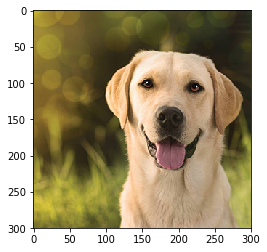

Your predicted breed is Labrador retriever

-----------------------------

Hello Unidentified Species


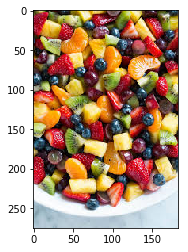

An Error has occured

-----------------------------

Hello Human!


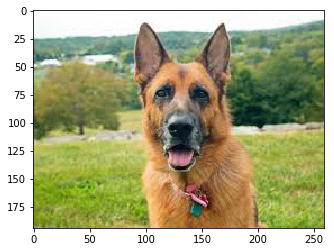

You look like a German shepherd dog

-----------------------------

Hello Dog!


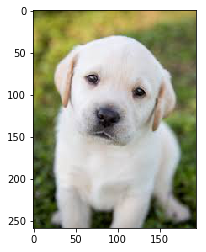

Your predicted breed is Labrador retriever

-----------------------------

Hello Human!


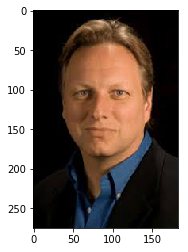

You look like a American staffordshire terrier

-----------------------------

Hello Human!


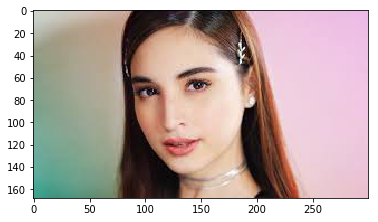

You look like a Chinese crested

-----------------------------



In [196]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

computer_files = np.array(glob("computer_images/*"))
for file in np.hstack((computer_files[:6])):
    run_app(file)

As you can see, the algorithms are not perfect, but with more training could reach a higher accuracy.

---
The pretrained models are included in the GitHub Repository if you are interested in trying them out yourself!